In [3]:
import sys
import os
# Manually set the path relative to the py file's location that you want to import
func_lib_path = os.path.abspath(os.path.join(os.getcwd(), '../'))

# Add the path to sys.path
sys.path.append(func_lib_path)

# Now you can import func_lib
import func_lib

In [4]:
import pandas as pd

In [5]:
# Set display options to round to 2 decimal places
pd.options.display.float_format = "{:.2f}".format

In [6]:
historical_prices = func_lib.createHistPrices()
# Create a list of momentums for 1d and 2d returns
list_of_momentums = [1,2]
# Run the function computingReturns and save the output as total_data
total_returns = func_lib.computingReturns(historical_prices, list_of_momentums)
#Print the first 5 rows of total_data

[*********************100%%**********************]  501 of 501 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1714536000")


In [7]:
# Create a function to calculate RSI using prices
'''
def calculate_rsi(prices, window=14):    
    gain = prices[prices>0].dropna().rolling(window=window).mean()
    #gain.rename(columns={prices.columns[0]:'gain'}, inplace=True)
    gain.name = 'gain'
    loss = prices[prices<0].dropna().rolling(window=window).mean()
    #loss.rename(columns={prices.columns[0]:'loss'}, inplace=True)
    loss.name = 'loss'
    prices = pd.merge(prices, gain, left_index=True, right_index=True, how='left')
    prices = pd.merge(prices, loss, left_index=True, right_index=True, how='left')
    prices = prices.ffill()
    prices.dropna(inplace=True)
    ratio = prices['gain']/abs(prices['loss'])
    rsi = 100 - (100 / (1 + ratio))
    return rsi
'''

"\ndef calculate_rsi(prices, window=14):    \n    gain = prices[prices>0].dropna().rolling(window=window).mean()\n    #gain.rename(columns={prices.columns[0]:'gain'}, inplace=True)\n    gain.name = 'gain'\n    loss = prices[prices<0].dropna().rolling(window=window).mean()\n    #loss.rename(columns={prices.columns[0]:'loss'}, inplace=True)\n    loss.name = 'loss'\n    prices = pd.merge(prices, gain, left_index=True, right_index=True, how='left')\n    prices = pd.merge(prices, loss, left_index=True, right_index=True, how='left')\n    prices = prices.ffill()\n    prices.dropna(inplace=True)\n    ratio = prices['gain']/abs(prices['loss'])\n    rsi = 100 - (100 / (1 + ratio))\n    return rsi\n"

In [8]:
# Create a function to calculate RSI using returns
def calculate_rsi(returns, window=14):    
    gain = returns[returns>0].dropna().rolling(window=window).mean()    
    gain.name = 'gain'
    loss = returns[returns<0].dropna().rolling(window=window).mean()    
    loss.name = 'loss'
    returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')    
    returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')
    returns = returns.ffill()
    returns.dropna(inplace=True)
    ratio = returns['gain']/abs(returns['loss'])
    rsi = 100 - (100 / (1 + ratio))
    return rsi

In [9]:
# Calculate RSI for each ticker separately and add to the DataFrame
total_returns['RSI'] = total_returns.groupby('Ticker')[['1_d_returns']].transform(calculate_rsi)

In [10]:
# Create the predicted and true values of F_1_d_returns as being larger or smaller than 0
#total_returns['y_test'] = np.where(total_data['F_1_d_returns']>0,1,0)
#total_returns['y_pred'] = total_data['Position']


In [11]:
total_returns.tail()

F_1_d_returns  1_d_returns  2_d_returns   RSI
Ticker Date                                                     
ZTS    2024-04-23           0.01         0.03         0.02 38.83
       2024-04-24           0.02         0.01         0.04 38.66
       2024-04-25           0.03         0.02         0.03 40.47
       2024-04-26           0.01         0.03         0.05 44.58
       2024-04-29          -0.00         0.01         0.04 44.68

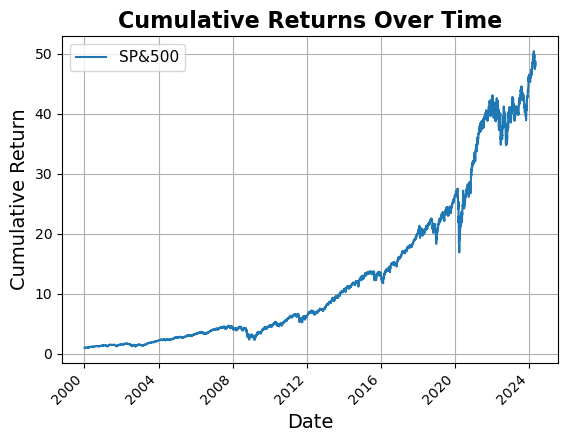

The CAGR is: 17.14%
Sharpe Ratio of Strategy: 0.88
The CAGR is: 0.42%
Sharpe Ratio of Strategy: 0.37


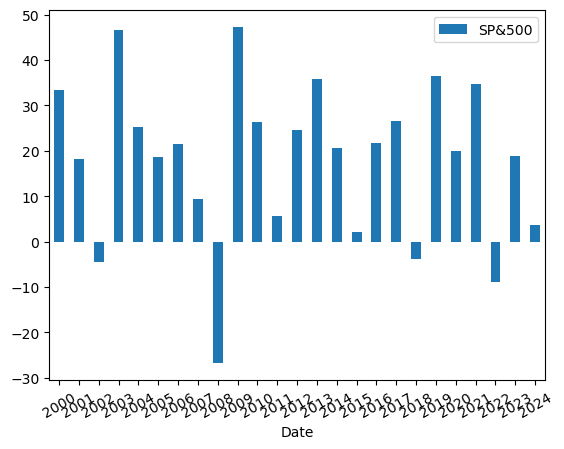

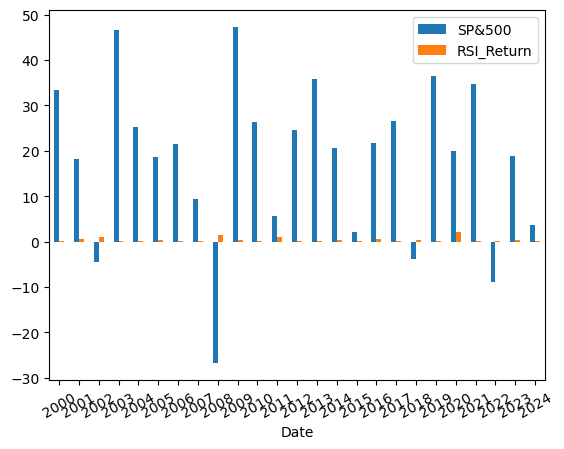

In [15]:
# Define trading strategy based on RSI
def trading_strategy(rsi):
    if rsi < 30:
        return  1 # Go long
    else:
        return 0
model_name = "RSI"
cum_returns, calendar_returns = func_lib.compute_BM_Perf(total_returns)
cum_returns, calendar_returns = func_lib.compute_Strat_Perf(total_returns, cum_returns, calendar_returns, trading_strategy, model_name)

In [5]:
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol for S&P 500
stock_ticker = 'SPY'

# Download historical data for S&P 500 since 1980
stock_data = yf.download(stock_ticker, start='1980-01-01', end='2024-01-01')['Adj Close']

# Download historical data for 10-Year Treasury Bond from FRED
bond_data = web.DataReader('DGS10', 'fred', start='1980-01-01', end='2024-01-01')



[*********************100%%**********************]  1 of 1 completed


In [70]:
# Resample bond data to match the frequency of stock data (daily) and forward fill missing values
#bond_data = bond_data.resample('D').ffill()

# Calculate the daily returns for both stock and bond data
stock_returns = stock_data.pct_change().dropna()
bond_returns = bond_data.pct_change().dropna()



C:\Users\metin\AppData\Local\Temp\ipykernel_16032\1504623157.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  bond_returns = bond_data.pct_change().dropna()


In [72]:
# Combine the data into a single DataFrame
returns = pd.merge(pd.DataFrame(stock_returns), bond_returns, left_index=True, right_index=True)
returns.rename(columns={'Adj Close': 'SP500', 'DGS10': '10Y_Treasury'}, inplace=True)



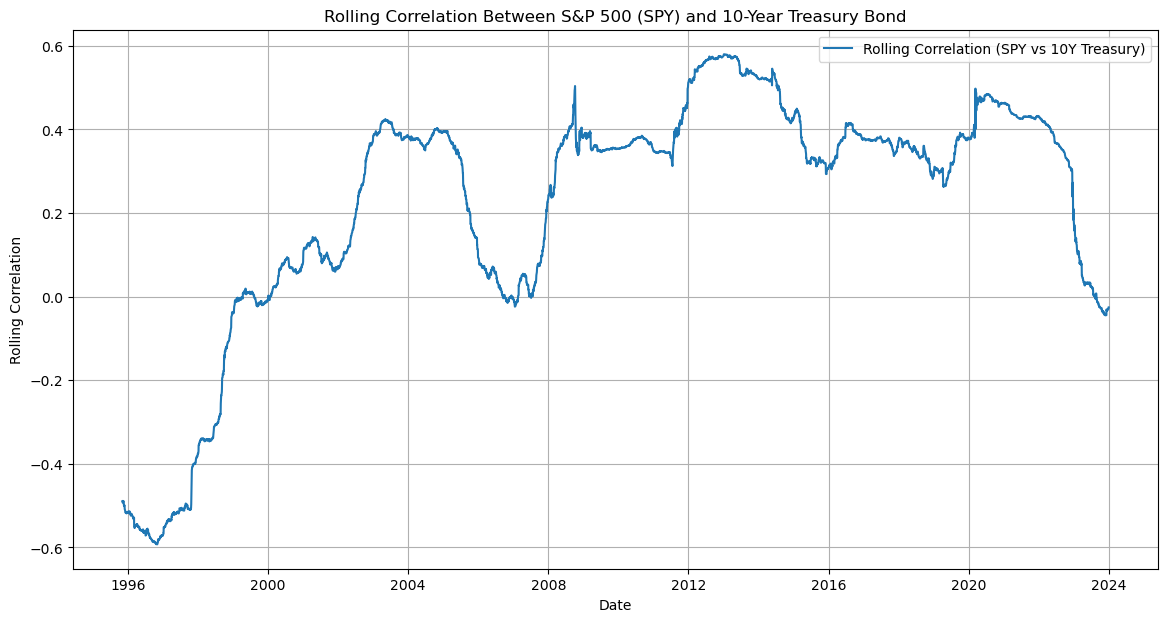

In [74]:
# Calculate the rolling correlation with a window of 252 trading days (approximately 1 year)
rolling_corr = returns['SP500'].rolling(window=700).corr(returns['10Y_Treasury'])

# Plot the rolling correlation
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr, label='Rolling Correlation (SPY vs 10Y Treasury)')
plt.title('Rolling Correlation Between S&P 500 (SPY) and 10-Year Treasury Bond')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  2 of 2 completed


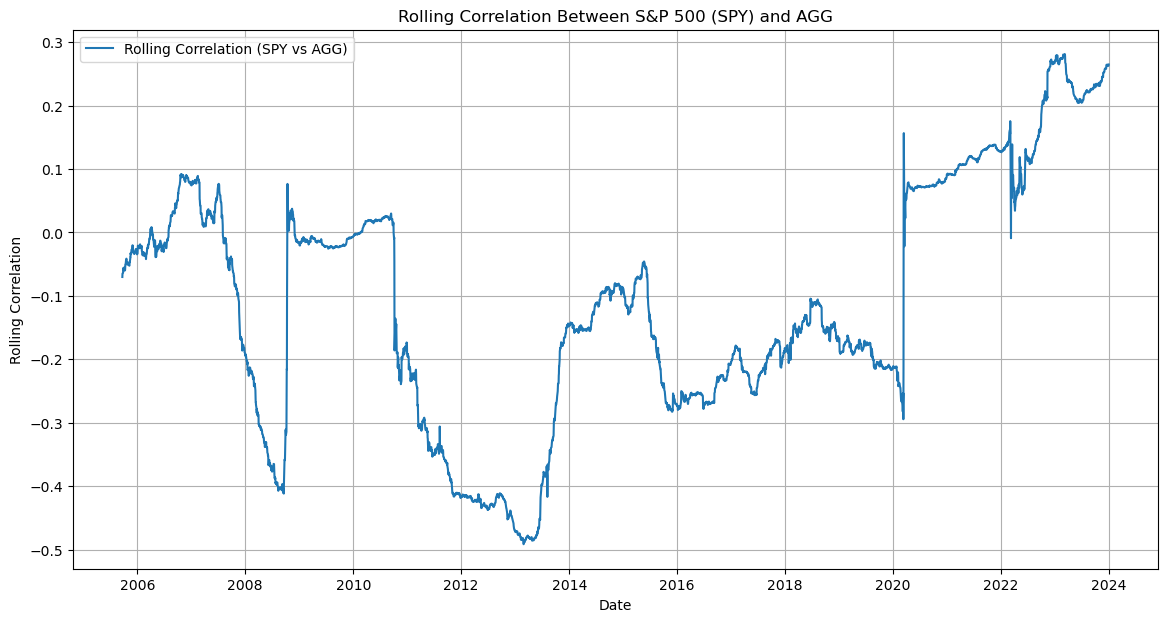

In [76]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbols for S&P 500 and AGG
tickers = ['SPY', 'AGG']

# Download historical data since 1980
data = yf.download(tickers, start='1980-01-01', end='2024-01-01')['Adj Close']

# Calculate the daily returns
returns = data.pct_change().dropna()

# Calculate the rolling correlation with a window of 252 trading days (approximately 1 year)
rolling_corr = returns['SPY'].rolling(window=500).corr(returns['AGG'])

# Plot the rolling correlation
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr, label='Rolling Correlation (SPY vs AGG)')
plt.title('Rolling Correlation Between S&P 500 (SPY) and AGG')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Import yfinance library
import yfinance as yf
import pandas as pd

# Define the start and end dates  
start_date = '2024-04-01'
end_date   = '2024-05-01'

# Define the list of tickers
tickers = ['AAPL', 'MSFT']

# Download historical prices for the list of tickers
historical_prices = yf.download(tickers, start=start_date, end=end_date)

historical_prices.head()

[*********************100%%**********************]  2 of 2 completed


Price        Adj Close                   Close                    High  \
Ticker            AAPL        MSFT        AAPL        MSFT        AAPL   
Date                                                                     
2024-04-01  169.603378  423.043060  170.029999  424.570007  171.250000   
2024-04-02  168.416351  419.924347  168.839996  421.440002  169.339996   
2024-04-03  169.224319  418.937897  169.649994  420.450012  170.679993   
2024-04-04  168.396423  416.377136  168.820007  417.880005  171.919998   
2024-04-05  169.154495  423.989624  169.580002  425.519989  170.389999   

Price                          Low                    Open              \
Ticker            MSFT        AAPL        MSFT        AAPL        MSFT   
Date                                                                     
2024-04-01  427.890015  169.479996  422.220001  171.190002  423.950012   
2024-04-02  422.380005  168.229996  417.839996  169.080002  420.109985   
2024-04-03  423.260010  168.580002  419.089996  168.789993  419.730011   
2024-04-04  428.670013  168.820007  417.570007  170.289993  424.989990   
2024-04-05  426.510010  168.949997  418.320007  169.589996  420.010010   

Price         Volume            
Ticker          AAPL      MSFT  
Date                            
2024-04-01  46240500  16316000  
2024-04-02  49329500  17912000  
2024-04-03  47691700  16502300  
2024-04-04  53704400  19370900  
2024-04-05  42055200  16544300

In [20]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [23]:
# Define the list of tickers
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()
sp500_tickers[1:10]

['AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [25]:
# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

In [27]:
new_sp500_tickers = []
for ticker in sp500_tickers:
    if '.B' not in sp500_tickers:
        new_sp500_tickers.append(ticker)
sp500_tickers = new_sp500_tickers

In [29]:
# Import yfinance library
import yfinance as yf
import pandas as pd

# Define the start and end dates  
start_date = '2000-01-01'
end_date   = '2024-05-01'

# Define the list of tickers
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

# Download historical prices for the list of tickers
historical_prices = yf.download(sp500_tickers, start=start_date, end=end_date)

historical_prices.head()

[**********************75%%**********            ]  374 of 501 completed

$MTB: possibly delisted; No price data found  (1d 2000-01-01 -> 2024-05-01)


[*********************100%%**********************]  501 of 501 completed

2 Failed downloads:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1714536000")
['MTB']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2000-01-01 -> 2024-05-01)')


Price      Adj Close                                                         \
Ticker             A AAL   AAPL ABBV ABNB    ABT   ACGL ACN    ADBE     ADI   
Date                                                                          
2000-01-03   43.5322 NaN 0.8440  NaN  NaN 8.3272 1.2778 NaN 16.2747 28.3256   
2000-01-04   40.2068 NaN 0.7728  NaN  NaN 8.0893 1.2708 NaN 14.9094 26.8927   
2000-01-05   37.7128 NaN 0.7842  NaN  NaN 8.0744 1.3889 NaN 15.2042 27.2853   
2000-01-06   36.2768 NaN 0.7163  NaN  NaN 8.3570 1.3750 NaN 15.3283 26.5393   
2000-01-07   39.2999 NaN 0.7502  NaN  NaN 8.4462 1.4514 NaN 16.0730 27.2853   

Price       ... Volume                                                    \
Ticker      ...    WTW       WY WYNN      XEL       XOM XYL      YUM ZBH   
Date        ...                                                            
2000-01-03  ...    NaN   973700  NaN  2738600  13458200 NaN  3033493 NaN   
2000-01-04  ...    NaN  1201700  NaN   425200  14510800 NaN  3315031 NaN   
2000-01-05  ...    NaN  1184600  NaN   500200  17485000 NaN  4642602 NaN   
2000-01-06  ...    NaN  1307700  NaN   344100  19461600 NaN  3947658 NaN   
2000-01-07  ...    NaN  1728000  NaN   469500  16603800 NaN  6063647 NaN   

Price                    
Ticker         ZBRA ZTS  
Date                     
2000-01-03  1055700 NaN  
2000-01-04   522450 NaN  
2000-01-05   612225 NaN  
2000-01-06   263925 NaN  
2000-01-07   333900 NaN  

[5 rows x 3006 columns]

In [30]:
# Backup to prevent having to pull again
#historical_prices_backup = historical_prices
#historical_prices = historical_prices_backup

In [31]:
historical_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6120 entries, 2000-01-03 to 2024-04-30
Columns: 3006 entries, ('Adj Close', 'A') to ('Volume', 'ZTS')
dtypes: float64(2654), int64(352)
memory usage: 140.4 MB


In [32]:
historical_prices.loc['2024-04-01':'2024-04-02'].head()

Price      Adj Close                                                      \
Ticker             A     AAL     AAPL     ABBV     ABNB      ABT    ACGL   
Date                                                                       
2024-04-01  145.2904 15.4100 169.6034 177.4573 163.3700 110.9482 92.3100   
2024-04-02  143.9029 14.4000 168.4164 177.3886 160.1100 110.8789 91.4900   

Price                                  ...      Volume                        \
Ticker          ACN     ADBE      ADI  ...         WTW       WY         WYNN   
Date                                   ...                                     
2024-04-01 336.3866 502.0900 195.8410  ... 318300.0000  2203000 2954200.0000   
2024-04-02 333.6988 499.2100 194.1079  ... 622400.0000  3464200 1716000.0000   

Price                                                                     \
Ticker          XEL       XOM          XYL      YUM          ZBH    ZBRA   
Date                                                                       
2024-04-01  4266600  13817000  716800.0000  2227600  745000.0000  416900   
2024-04-02  4561600  19919600 1144400.0000  1987400 1057000.0000  461500   

Price                    
Ticker              ZTS  
Date                     
2024-04-01 1896500.0000  
2024-04-02 2391500.0000  

[2 rows x 3006 columns]

In [33]:
historical_prices.loc['2024-04'].head()

Price      Adj Close                                                      \
Ticker             A     AAL     AAPL     ABBV     ABNB      ABT    ACGL   
Date                                                                       
2024-04-01  145.2904 15.4100 169.6034 177.4573 163.3700 110.9482 92.3100   
2024-04-02  143.9029 14.4000 168.4164 177.3886 160.1100 110.8789 91.4900   
2024-04-03  143.4637 14.1600 169.2243 174.0900 159.3400 110.1465 92.2300   
2024-04-04  141.0782 13.8300 168.3964 164.8323 158.8400 108.9884 91.0900   
2024-04-05  143.8530 13.7600 169.1545 166.8939 161.7700 110.0673 94.9000   

Price                                  ...      Volume                        \
Ticker          ACN     ADBE      ADI  ...         WTW       WY         WYNN   
Date                                   ...                                     
2024-04-01 336.3866 502.0900 195.8410  ... 318300.0000  2203000 2954200.0000   
2024-04-02 333.6988 499.2100 194.1079  ... 622400.0000  3464200 1716000.0000   
2024-04-03 329.5531 497.0100 194.5860  ... 449700.0000  3122100 1321500.0000   
2024-04-04 327.7579 487.1100 191.1895  ... 350800.0000  3143500 2412000.0000   
2024-04-05 330.2672 485.1200 193.9884  ... 439700.0000  2662500 1437600.0000   

Price                                                                     \
Ticker          XEL       XOM          XYL      YUM          ZBH    ZBRA   
Date                                                                       
2024-04-01  4266600  13817000  716800.0000  2227600  745000.0000  416900   
2024-04-02  4561600  19919600 1144400.0000  1987400 1057000.0000  461500   
2024-04-03  4122600  16504300 1147300.0000  1543800 1369900.0000  399300   
2024-04-04  7021900  18467400 1129500.0000  2640400 1032900.0000  390700   
2024-04-05  4483900  21714100  753600.0000  1735600  791700.0000  216700   

Price                    
Ticker              ZTS  
Date                     
2024-04-01 1896500.0000  
2024-04-02 2391500.0000  
2024-04-03 2481200.0000  
2024-04-04 4306100.0000  
2024-04-05 3663900.0000  

[5 rows x 3006 columns]

In [34]:
# Filter and keep only columns where the first level of the MultiIndex is 'Adj Close'
historical_prices  = historical_prices.loc[:, historical_prices.columns.get_level_values(0) == 'Adj Close']
historical_prices.head()

Price      Adj Close                                                         \
Ticker             A AAL   AAPL ABBV ABNB    ABT   ACGL ACN    ADBE     ADI   
Date                                                                          
2000-01-03   43.5322 NaN 0.8440  NaN  NaN 8.3272 1.2778 NaN 16.2747 28.3256   
2000-01-04   40.2068 NaN 0.7728  NaN  NaN 8.0893 1.2708 NaN 14.9094 26.8927   
2000-01-05   37.7128 NaN 0.7842  NaN  NaN 8.0744 1.3889 NaN 15.2042 27.2853   
2000-01-06   36.2768 NaN 0.7163  NaN  NaN 8.3570 1.3750 NaN 15.3283 26.5393   
2000-01-07   39.2999 NaN 0.7502  NaN  NaN 8.4462 1.4514 NaN 16.0730 27.2853   

Price       ...                                                             
Ticker      ... WTW      WY WYNN    XEL     XOM XYL    YUM ZBH    ZBRA ZTS  
Date        ...                                                             
2000-01-03  ... NaN 11.4279  NaN 6.9076 18.0358 NaN 4.6574 NaN 25.0278 NaN  
2000-01-04  ... NaN 10.9986  NaN 7.0667 17.6904 NaN 4.5638 NaN 24.6667 NaN  
2000-01-05  ... NaN 11.5812  NaN 7.3394 18.6548 NaN 4.5872 NaN 25.1389 NaN  
2000-01-06  ... NaN 12.1230  NaN 7.2712 19.6192 NaN 4.5482 NaN 23.7778 NaN  
2000-01-07  ... NaN 11.7243  NaN 7.2712 19.5616 NaN 4.4468 NaN 23.5139 NaN  

[5 rows x 501 columns]

In [35]:
# Remove the MultiIndex and keep only the second level
historical_prices.columns = historical_prices.columns.droplevel(0)   
historical_prices.head()


Ticker           A  AAL   AAPL  ABBV  ABNB    ABT   ACGL  ACN    ADBE     ADI  \
Date                                                                            
2000-01-03 43.5322  NaN 0.8440   NaN   NaN 8.3272 1.2778  NaN 16.2747 28.3256   
2000-01-04 40.2068  NaN 0.7728   NaN   NaN 8.0893 1.2708  NaN 14.9094 26.8927   
2000-01-05 37.7128  NaN 0.7842   NaN   NaN 8.0744 1.3889  NaN 15.2042 27.2853   
2000-01-06 36.2768  NaN 0.7163   NaN   NaN 8.3570 1.3750  NaN 15.3283 26.5393   
2000-01-07 39.2999  NaN 0.7502   NaN   NaN 8.4462 1.4514  NaN 16.0730 27.2853   

Ticker      ...  WTW      WY  WYNN    XEL     XOM  XYL    YUM  ZBH    ZBRA  \
Date        ...                                                              
2000-01-03  ...  NaN 11.4279   NaN 6.9076 18.0358  NaN 4.6574  NaN 25.0278   
2000-01-04  ...  NaN 10.9986   NaN 7.0667 17.6904  NaN 4.5638  NaN 24.6667   
2000-01-05  ...  NaN 11.5812   NaN 7.3394 18.6548  NaN 4.5872  NaN 25.1389   
2000-01-06  ...  NaN 12.1230   NaN 7.2712 19.6192  NaN 4.5482  NaN 23.7778   
2000-01-07  ...  NaN 11.7243   NaN 7.2712 19.5616  NaN 4.4468  NaN 23.5139   

Ticker      ZTS  
Date             
2000-01-03  NaN  
2000-01-04  NaN  
2000-01-05  NaN  
2000-01-06  NaN  
2000-01-07  NaN  

[5 rows x 501 columns]

In [36]:
MIN_REQUIRED_NUM_OBS_PER_TICKER = 100

# Count non-missing values for each ticker
ticker_counts = historical_prices.count()
ticker_counts

Ticker
A       6120
AAL     4679
AAPL    6120
ABBV    2851
ABNB     851
        ... 
XYL     3156
YUM     6120
ZBH     5727
ZBRA    6120
ZTS     2830
Length: 501, dtype: int64

In [37]:
# Filter out tickers with fewer than n=MIN_REQUIRED_NUM_OBS_PER_TICKER=100 non-missing values
valid_tickers_mask = ticker_counts[ticker_counts >= MIN_REQUIRED_NUM_OBS_PER_TICKER].index
valid_tickers_mask

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=497)

In [38]:
historical_prices

Ticker            A     AAL     AAPL     ABBV     ABNB      ABT    ACGL  \
Date                                                                      
2000-01-03  43.5322     NaN   0.8440      NaN      NaN   8.3272  1.2778   
2000-01-04  40.2068     NaN   0.7728      NaN      NaN   8.0893  1.2708   
2000-01-05  37.7128     NaN   0.7842      NaN      NaN   8.0744  1.3889   
2000-01-06  36.2768     NaN   0.7163      NaN      NaN   8.3570  1.3750   
2000-01-07  39.2999     NaN   0.7502      NaN      NaN   8.4462  1.4514   
...             ...     ...      ...      ...      ...      ...     ...   
2024-04-24 137.2353 13.9200 168.5959 166.2726 162.8400 106.3259 93.1900   
2024-04-25 136.1174 14.1300 169.4637 165.7672 163.0100 106.2961 93.0500   
2024-04-26 137.4848 13.8800 168.8752 158.1670 164.2300 106.9625 90.9000   
2024-04-29 139.3314 13.9800 173.0647 160.0497 162.2500 106.7039 91.2500   
2024-04-30 136.7861 13.5100 169.9026 161.1595 158.5700 105.4108 93.5400   

Ticker          ACN     ADBE      ADI  ...      WTW      WY    WYNN     XEL  \
Date                                   ...                                    
2000-01-03      NaN  16.2747  28.3256  ...      NaN 11.4279     NaN  6.9076   
2000-01-04      NaN  14.9094  26.8927  ...      NaN 10.9986     NaN  7.0667   
2000-01-05      NaN  15.2042  27.2853  ...      NaN 11.5812     NaN  7.3394   
2000-01-06      NaN  15.3283  26.5393  ...      NaN 12.1230     NaN  7.2712   
2000-01-07      NaN  16.0730  27.2853  ...      NaN 11.7243     NaN  7.2712   
...             ...      ...      ...  ...      ...     ...     ...     ...   
2024-04-24 312.1710 477.1200 195.7215  ... 263.5985 31.3278 96.4929 54.7720   
2024-04-25 307.6508 473.4400 197.1558  ... 256.0637 31.2483 96.0356 54.4552   
2024-04-26 306.6651 477.5600 201.1698  ... 250.1136 30.8410 95.3198 53.4158   
2024-04-29 301.8363 473.0700 203.0922  ... 251.5887 30.9702 96.4134 53.9306   
2024-04-30 299.5961 462.8300 199.8152  ... 250.3030 29.9670 91.1145 53.1882   

Ticker          XOM      XYL      YUM      ZBH     ZBRA      ZTS  
Date                                                              
2000-01-03  18.0358      NaN   4.6574      NaN  25.0278      NaN  
2000-01-04  17.6904      NaN   4.5638      NaN  24.6667      NaN  
2000-01-05  18.6548      NaN   4.5872      NaN  25.1389      NaN  
2000-01-06  19.6192      NaN   4.5482      NaN  23.7778      NaN  
2000-01-07  19.5616      NaN   4.4468      NaN  23.5139      NaN  
...             ...      ...      ...      ...      ...      ...  
2024-04-24 119.1157 130.3290 141.1165 120.9013 277.5300 150.5220  
2024-04-25 119.3912 130.2691 140.8678 119.4844 292.5300 152.9961  
2024-04-26 116.0751 132.0545 141.0767 119.0853 297.2100 158.0441  
2024-04-29 117.7282 132.2440 142.4898 121.4401 300.0100 159.3210  
2024-04-30 116.3801 130.3589 140.5593 120.0133 314.5600 158.8621  

[6120 rows x 501 columns]

In [39]:
# Filter the DataFrame based on valid tickers
historical_prices = historical_prices[valid_tickers_mask]

[*********************100%%**********************]  501 of 501 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1714536000")


In [23]:
# Create a function called 'computingReturns' that takes  prices and a list of integers (momentums) as an input
def computingReturns(prices, list_of_momentums): 
    '''
    Takes as an input a dataframe of prices and a list of momentums 
    and returns a dataframe with returns over the momentum list and 1 day forward returns
    '''

    # Return the total returns DataFrame
    return total_returns


In [24]:
prices = historical_prices
list_of_momentums = [1,2]

In [27]:
historical_prices.head()

Ticker         A  AAL  AAPL  ABBV  ABNB  ABT  ACGL  ACN  ADBE   ADI  ...  WTW  \
Date                                                                 ...        
2000-01-03 43.53  NaN  0.84   NaN   NaN 8.37  1.28  NaN 16.27 28.33  ...  NaN   
2000-01-04 40.21  NaN  0.77   NaN   NaN 8.13  1.27  NaN 14.91 26.89  ...  NaN   
2000-01-05 37.71  NaN  0.79   NaN   NaN 8.12  1.39  NaN 15.20 27.29  ...  NaN   
2000-01-06 36.28  NaN  0.72   NaN   NaN 8.40  1.38  NaN 15.33 26.54  ...  NaN   
2000-01-07 39.30  NaN  0.75   NaN   NaN 8.49  1.45  NaN 16.07 27.29  ...  NaN   

Ticker        WY  WYNN  XEL   XOM  XYL  YUM  ZBH  ZBRA  ZTS  
Date                                                         
2000-01-03 11.43   NaN 6.91 18.18  NaN 4.66  NaN 25.03  NaN  
2000-01-04 11.00   NaN 7.07 17.83  NaN 4.56  NaN 24.67  NaN  
2000-01-05 11.58   NaN 7.34 18.80  NaN 4.59  NaN 25.14  NaN  
2000-01-06 12.12   NaN 7.27 19.78  NaN 4.55  NaN 23.78  NaN  
2000-01-07 11.72   NaN 7.27 19.72  NaN 4.45  NaN 23.51  NaN  

[5 rows x 498 columns]

In [33]:
# Initialize the forecast horizon
forecast_horizon = 1
# Compute forward returns by taking percentage change of close prices
f_returns = prices.pct_change(forecast_horizon, fill_method=None)
f_returns.iloc[:,0:10].head()

Ticker         A  AAL  AAPL  ABBV  ABNB   ABT  ACGL  ACN  ADBE   ADI
Date                                                                
2000-01-03   NaN  NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN
2000-01-04 -0.08  NaN -0.08   NaN   NaN -0.03 -0.01  NaN -0.08 -0.05
2000-01-05 -0.06  NaN  0.01   NaN   NaN -0.00  0.09  NaN  0.02  0.01
2000-01-06 -0.04  NaN -0.09   NaN   NaN  0.03 -0.01  NaN  0.01 -0.03
2000-01-07  0.08  NaN  0.05   NaN   NaN  0.01  0.06  NaN  0.05  0.03

In [30]:
f_returns[['AAPL']].head()

Ticker      AAPL
Date            
2000-01-03   NaN
2000-01-04 -0.08
2000-01-05  0.01
2000-01-06 -0.09
2000-01-07  0.05

In [31]:
prices[['AAPL']].head()

Ticker      AAPL
Date            
2000-01-03  0.84
2000-01-04  0.77
2000-01-05  0.79
2000-01-06  0.72
2000-01-07  0.75

In [76]:
(168.611298-169.799698)/169.799698

-0.006998834591566832

In [35]:
# We then shift the forward returns
f_returns = f_returns.shift(-forecast_horizon)
f_returns.iloc[:,0:10].head()

Ticker         A  AAL  AAPL  ABBV  ABNB   ABT  ACGL  ACN  ADBE   ADI
Date                                                                
2000-01-03 -0.06  NaN  0.01   NaN   NaN -0.00  0.09  NaN  0.02  0.01
2000-01-04 -0.04  NaN -0.09   NaN   NaN  0.03 -0.01  NaN  0.01 -0.03
2000-01-05  0.08  NaN  0.05   NaN   NaN  0.01  0.06  NaN  0.05  0.03
2000-01-06  0.06  NaN -0.02   NaN   NaN -0.01  0.03  NaN  0.04  0.09
2000-01-07 -0.01  NaN -0.05   NaN   NaN -0.01  0.01  NaN -0.07 -0.04

In [36]:
# Pivot the dataframe
f_returns = pd.DataFrame(f_returns.unstack())
# Name the column based on the forecast horizon
name = "F_" + str(forecast_horizon) + "_d_returns"
f_returns.rename(columns={0: name}, inplace=True)
f_returns.head()

F_1_d_returns
Ticker Date                     
A      2000-01-03          -0.06
       2000-01-04          -0.04
       2000-01-05           0.08
       2000-01-06           0.06
       2000-01-07          -0.01

In [37]:
# Initialize total_returns with forward returns
total_returns = f_returns

In [38]:
total_returns.shape

(3047760, 1)

In [39]:
list_of_momentums = [1,2]

In [40]:
# Iterate over the list of momentum values
for i in list_of_momentums:   
    # Compute returns for each momentum value
    feature = prices.pct_change(i)
    feature = pd.DataFrame(feature.unstack())
    # Name the column based on the momentum value
    name = str(i) + "_d_returns"        
    feature.rename(columns={0: name}, inplace=True)
    # Rename columns and reset index
    feature.rename(columns={0: name, 'level_0': 'Ticker'}, inplace=True)
    # Merge computed feature returns with total_returns based on Ticker and Date
    total_returns = pd.merge(total_returns, feature, left_index=True, right_index=True,how='outer')

total_returns.head()

F_1_d_returns  1_d_returns  2_d_returns
Ticker Date                                               
A      2000-01-03          -0.06          NaN          NaN
       2000-01-04          -0.04        -0.08          NaN
       2000-01-05           0.08        -0.06        -0.13
       2000-01-06           0.06        -0.04        -0.10
       2000-01-07          -0.01         0.08         0.04

In [41]:
# Drop rows with any NaN values
total_returns.dropna(axis=0, how='any', inplace=True) 
total_returns.head()

F_1_d_returns  1_d_returns  2_d_returns
Ticker Date                                               
A      2000-01-05           0.08        -0.06        -0.13
       2000-01-06           0.06        -0.04        -0.10
       2000-01-07          -0.01         0.08         0.04
       2000-01-10          -0.02         0.06         0.15
       2000-01-11           0.02        -0.01         0.05

[*********************100%%**********************]  501 of 501 completed

1 Failed download:
['SW']: YFChartError("%ticker%: Data doesn't exist for startDate = 946702800, endDate = 1714536000")


F_1_d_returns  1_d_returns  2_d_returns
Ticker Date                                               
A      2000-01-05          -0.04        -0.06        -0.13
       2000-01-06           0.08        -0.04        -0.10
       2000-01-07           0.06         0.08         0.04
       2000-01-10          -0.01         0.06         0.15
       2000-01-11          -0.02        -0.01         0.05

In [11]:
total_returns = total_returns.filter(items=['F_1_d_returns', '1_d_returns'])
total_returns.head()

F_1_d_returns  1_d_returns
Ticker Date                                  
A      2000-01-05          -0.04        -0.06
       2000-01-06           0.08        -0.04
       2000-01-07           0.06         0.08
       2000-01-10          -0.01         0.06
       2000-01-11          -0.02        -0.01

In [12]:
total_returns.index.get_level_values('Ticker').nunique()

498

In [13]:
total_returns.index.get_level_values('Date').value_counts().describe()

count   6117.00
mean     441.75
std       44.78
min      353.00
25%      406.00
50%      447.00
75%      483.00
max      498.00
Name: count, dtype: float64

In [14]:
# How many tickers do we have at each date?
tickers_per_date = total_returns.index.get_level_values('Date').value_counts()
tickers_per_date

Date
2024-04-29    498
2023-12-07    498
2023-12-18    498
2023-12-15    498
2023-12-14    498
             ... 
2000-01-26    353
2000-01-27    353
2000-01-28    353
2000-01-31    353
2000-01-05    353
Name: count, Length: 6117, dtype: int64

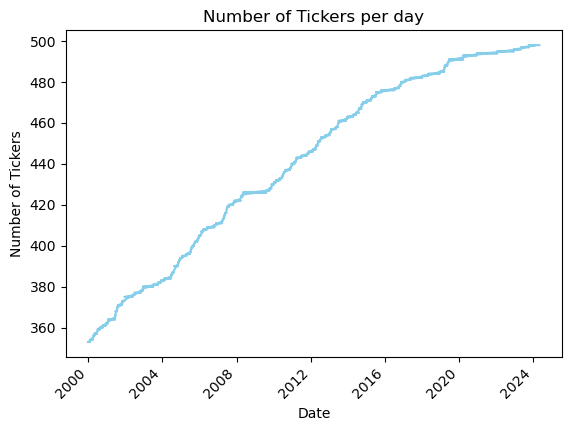

In [15]:
import matplotlib.pyplot as plt
tickers_per_date.plot(kind='line', color='skyblue')
plt.title('Number of Tickers per day')
plt.xlabel('Date')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=45)
plt.show()

In [16]:
pd.options.display.float_format = "{:,.4f}".format

In [19]:
total_returns.describe()

F_1_d_returns    1_d_returns
count 2,702,175.0000 2,702,175.0000
mean          0.0007         0.0007
std           0.0234         0.0234
min          -0.6805        -0.6805
25%          -0.0090        -0.0090
50%           0.0006         0.0006
75%           0.0102         0.0102
max           1.0236         1.0236

In [171]:
0.0007 * 252

0.1764

In [172]:
import numpy as np

In [173]:
np.sqrt(252)*  	0.0235 

0.3730509348601073

The CAGR is: 17.08%


Sharpe Ratio of Strategy: 0.88


:Bars   [Date]   (SP&500)

In [20]:
# Create a function to calculate RSI
def calculate_rsi(prices, window=14):
    
    return rsi

In [21]:
returns = total_returns[total_returns.index.get_level_values('Ticker')=='AAPL'][['1_d_returns']]
window = 6

In [22]:
delta = prices.diff()
delta.head()

NameError: name 'prices' is not defined

In [ ]:
gain = returns[returns>0].dropna().rolling(window=window).mean()
gain.rename(columns={returns.columns[0]:'gain'}, inplace=True)
gain.head(7)

In [ ]:
loss = returns[returns<0].dropna().rolling(window=window).mean()
loss.rename(columns={returns.columns[0]:'loss'}, inplace=True)
loss.head(7)

In [ ]:
returns = pd.merge(returns, gain, left_index=True, right_index=True, how='left')
returns = pd.merge(returns, loss, left_index=True, right_index=True, how='left')
returns.head(15)

In [ ]:
returns = returns.ffill().dropna()
returns.head()

In [ ]:
ratio = returns['gain']/abs(returns['loss'])
rsi = 100 - (100 / (1 + ratio))

In [18]:
prices = pd.DataFrame(historical_prices.unstack())
prices.rename(columns={0:'1_d_returns'}, inplace=True)
prices.head()

1_d_returns
Ticker Date                   
A      2000-01-03      43.5322
       2000-01-04      40.2069
       2000-01-05      37.7128
       2000-01-06      36.2769
       2000-01-07      39.2999

In [ ]:
total_returns[['RSI']].describe()

In [625]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


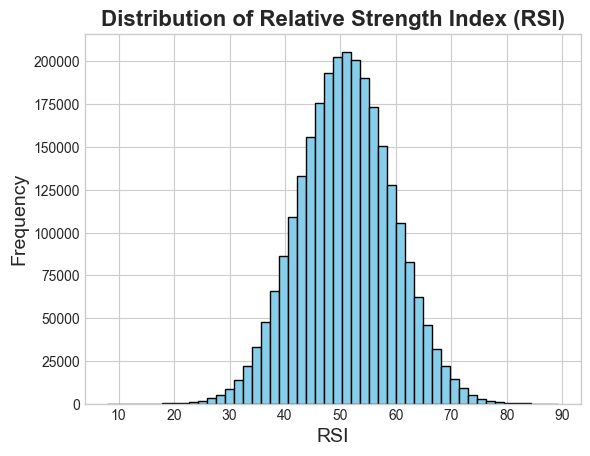

In [742]:
# Customizing the histogram
histogram_plot = total_returns[['RSI']].hist(bins=50, ax=plt.gca(), color='skyblue', edgecolor='black')

# Adding titles and labels
plt.title('Distribution of Relative Strength Index (RSI)', fontsize=16, fontweight='bold')
plt.xlabel('RSI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)  # Turn off gridlines for histograms

# Displaying the plot
plt.show()

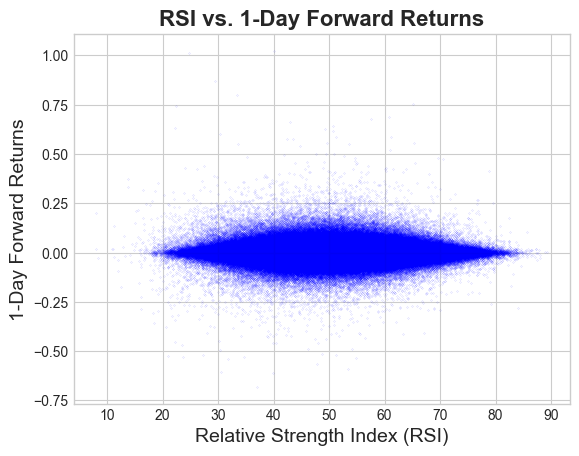

In [743]:
scatter_plot = total_returns.plot.scatter(x='RSI', y='F_1_d_returns', ax=plt.gca(), color='blue', alpha=0.6,s=0.01)

# Adding titles and labels
plt.title('RSI vs. 1-Day Forward Returns', fontsize=16, fontweight='bold')
plt.xlabel('Relative Strength Index (RSI)', fontsize=14)
plt.ylabel('1-Day Forward Returns', fontsize=14)
plt.grid(True)

# Displaying the plot
#plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [744]:
total_returns[['F_1_d_returns', 'RSI']].corr().style.background_gradient()

<Axes: xlabel='Quantiles'>

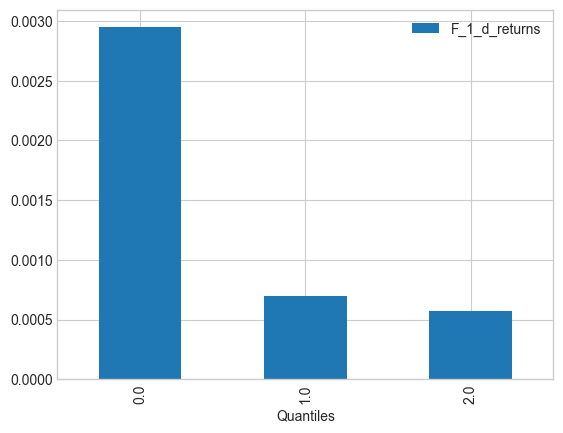

In [745]:
feature = 'RSI'
target = 'F_1_d_returns'

# Specify custom bin boundaries
bin_boundaries = [0, 30, 70, 100]

total_returns['Quantiles'] = total_returns.groupby(level='Date')[feature].transform(lambda x: pd.cut(x, bins=bin_boundaries, labels=False, precision=0, duplicates='drop'))

total_returns.groupby('Quantiles')[[target]].mean().plot(kind='bar', legend=True)

In [631]:
total_returns[total_returns['RSI']<30].describe()

F_1_d_returns  1_d_returns        RSI  Quantiles   Position  \
count     15909.0000   15909.0000 15909.0000 15909.0000 15909.0000   
mean          0.0029      -0.0153    27.2697     0.0000     1.0000   
std           0.0442       0.0491     2.5304     0.0000     0.0000   
min          -0.5314      -0.6805     8.0071     0.0000     1.0000   
25%          -0.0102      -0.0203    26.1460     0.0000     1.0000   
50%           0.0014      -0.0021    28.0188     0.0000     1.0000   
75%           0.0136       0.0055    29.1698     0.0000     1.0000   
max           1.0101       0.3510    29.9995     0.0000     1.0000   

       Realized_Ret  RSI_Return  
count    15909.0000  15909.0000  
mean         0.0029      0.0029  
std          0.0442      0.0442  
min         -0.5314     -0.5314  
25%         -0.0102     -0.0102  
50%          0.0014      0.0014  
75%          0.0136      0.0136  
max          1.0101      1.0101

In [27]:
total_returns.head()

F_1_d_returns  1_d_returns  2_d_returns
Ticker Date                                               
A      2000-01-05          -0.04        -0.06        -0.13
       2000-01-06           0.08        -0.04        -0.10
       2000-01-07           0.06         0.08         0.04
       2000-01-10          -0.01         0.06         0.15
       2000-01-11          -0.02        -0.01         0.05

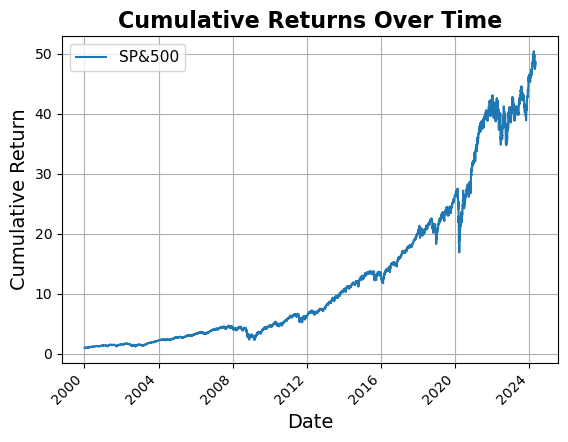

The CAGR is: 17.13%
Sharpe Ratio of Strategy: 0.88


KeyError: 'RSI'

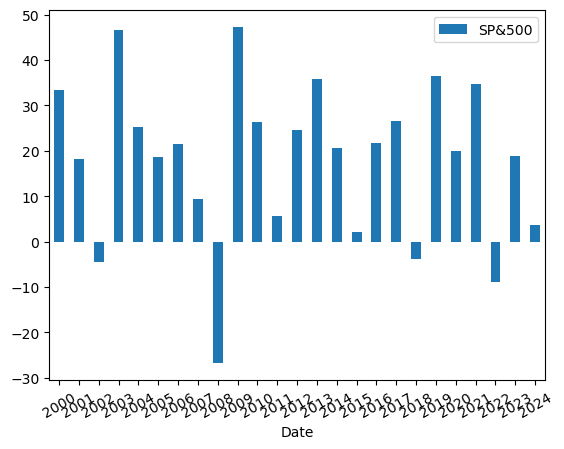

In [15]:
trading_strategy

<function __main__.trading_strategy(rsi)>

In [105]:
total_returns[total_returns['Position']==1][['F_1_d_returns']].describe()

F_1_d_returns
count    15,920.0000
mean          0.0030
std           0.0442
min          -0.5314
25%          -0.0102
50%           0.0014
75%           0.0136
max           1.0101

In [106]:
trades = total_returns[total_returns['Position']==1]
tickers_per_date =trades.index.get_level_values('Date').value_counts()
tickers_per_date.describe()

count   4,559.0000
mean        3.4920
std         5.1254
min         1.0000
25%         1.0000
50%         2.0000
75%         4.0000
max       111.0000
Name: count, dtype: float64

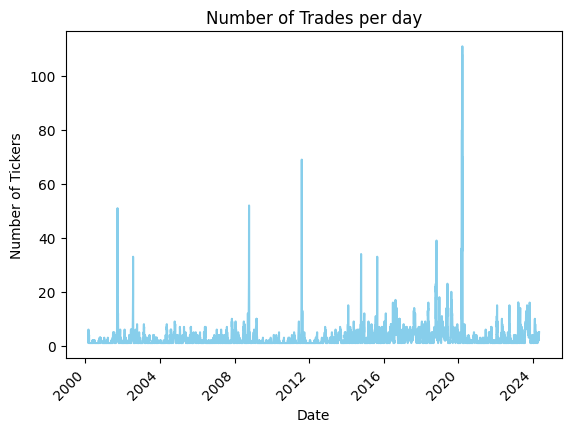

In [107]:
tickers_per_date.plot(kind='line', color='skyblue')
plt.title('Number of Trades per day')
plt.xlabel('Date')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=45)
plt.show()

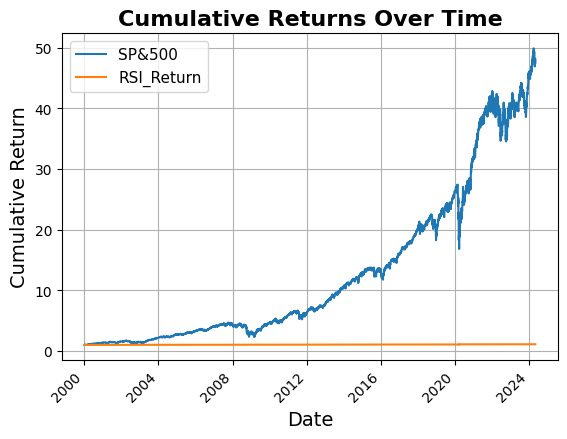

In [108]:
cum_returns.plot()
# Customizing the plot
plt.title('Cumulative Returns Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title_fontsize='13', fontsize='11')

# Display the plot
plt.show()

:Bars   [Date,Variable]   (value)

In [775]:
# Create the predicted and true values of F_1_d_returns as being larger or smaller than 0
total_returns['y_test'] = np.where(total_data['F_1_d_returns']>0,1,0)
total_returns['y_pred'] = total_data['Position']

# Define actual ansd predicted signals as lists
y_test = total_returns['y_test'].tolist()
y_pred = total_returns['y_pred'].tolist()


In [776]:
# Calculate accuracy, precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Create a DataFrame for the metrics
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Value': [accuracy, precision, recall]
})

metrics_df

Metric  Value
0   Accuracy 0.4866
1  Precision 0.5300
2     Recall 0.0061

In [779]:
# Count the number of each class
counts = total_returns['y_test'].value_counts()

# Calculate the share of each class
total = counts.sum()
shares = counts / total * 100
shares

y_test
1   51.3791
0   48.6209
Name: count, dtype: float64

In [113]:
# Define trading strategy based on RSI
def trading_strategy(rsi):
    if rsi < 60:
        return  1 # Go long
    else:
        return 0
        
# Apply trading strategy to each RSI value
total_returns['Position'] = total_returns[model_name].transform(trading_strategy)
# Create Returns for each Trade
total_returns[f'{model_name}_Return'] = total_returns['F_1_d_returns'] *  total_returns['Position'] 


In [114]:
total_returns.head()

F_1_d_returns  1_d_returns  RSI  Position  RSI_Return
Ticker Date                                                             
A      2000-01-05        -0.0381      -0.0620  NaN         0     -0.0000
       2000-01-06         0.0833      -0.0381  NaN         0      0.0000
       2000-01-07         0.0606       0.0833  NaN         0      0.0000
       2000-01-10        -0.0136       0.0606  NaN         0     -0.0000
       2000-01-11        -0.0202      -0.0136  NaN         0     -0.0000

In [115]:
# Define trading strategy based on RSI
def trading_strategy(rsi):
    if rsi < 30:
        return  1 # Go long
    else:
        return 0
        

# Compute the daily mean of all stocks. This will be our equal weighted benchmark
daily_mean  = pd.DataFrame(total_returns.loc[:,f'{model_name}_Return'].groupby(level='Date').mean())

# Convert daily returns to cumulative returns
cum_returns.loc[:,f'{model_name}_Return']  = pd.DataFrame((daily_mean[[f'{model_name}_Return']]+1).cumprod())

# Calculate the number of years in the dataset
number_of_years = len(daily_mean) / 252  # Assuming 252 trading days in a year

ending_value    = cum_returns[f'{model_name}_Return'].iloc[-1]
beginning_value = cum_returns[f'{model_name}_Return'].iloc[1]

ratio = ending_value/beginning_value
# Compute the Compound Annual Growth Rate (CAGR)
cagr = round((ratio**(1/number_of_years)-1)*100,2)

print(f'The CAGR is: {cagr}%')

# Compute the Sharpe Ratio by annualizing the daily mean and the daily std
average_daily_return  = daily_mean[[f'{model_name}_Return']].describe().iloc[1,:] * 252
stand_dev_dail_return   = daily_mean[[f'{model_name}_Return']].describe().iloc[2,:] * pow(252,1/2)

# Compute the Sharpe Ratio and print it out
sharpe  = average_daily_return/stand_dev_dail_return

print(f'Sharpe Ratio of Strategy: {round(sharpe.iloc[0],2)}')

ann_returns = (pd.DataFrame((daily_mean[f'{model_name}_Return']+1).groupby(daily_mean.index.get_level_values(0).year).cumprod())-1)*100


calendar_returns.loc[:,f'{model_name}_Return']  = pd.DataFrame(ann_returns[f'{model_name}_Return'].groupby(daily_mean.index.get_level_values(0).year).last())
calendar_returns.hvplot.bar(rot=30,  legend='top_left').opts(multi_level=False) 

The CAGR is: 14.98%
Sharpe Ratio of Strategy: 0.84


:Bars   [Date,Variable]   (value)

<Axes: xlabel='Date'>

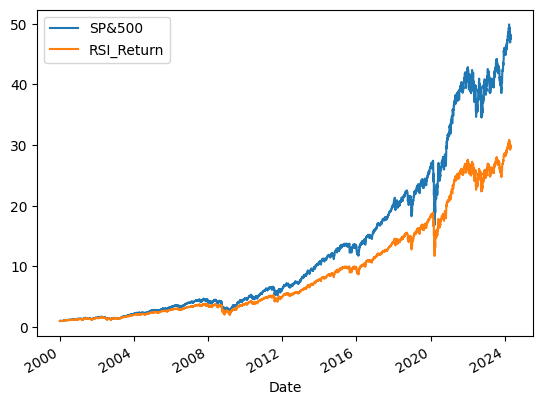

In [117]:
cum_returns.plot()

In [818]:
total_returns.head()

F_1_d_returns  1_d_returns  RSI  Quantiles  Position  \
Ticker Date                                                               
A      2000-01-05        -0.0381      -0.0620  NaN        NaN         0   
       2000-01-06         0.0833      -0.0381  NaN        NaN         0   
       2000-01-07         0.0606       0.0833  NaN        NaN         0   
       2000-01-10        -0.0136       0.0606  NaN        NaN         0   
       2000-01-11        -0.0202      -0.0136  NaN        NaN         0   

                   RSI_Return  y  y_pred  y_test  
Ticker Date                                       
A      2000-01-05     -0.0000  0       0       0  
       2000-01-06      0.0000  1       0       1  
       2000-01-07      0.0000  1       0       1  
       2000-01-10     -0.0000  0       0       0  
       2000-01-11     -0.0000  0       0       0

In [829]:
# Create the predicted and true values of F_1_d_returns as being larger or smaller than 0
total_returns['y_test'] = np.where(total_returns['F_1_d_returns']>0,1,0)
total_returns['y_pred'] = total_returns['Position']

# Define actual ansd predicted signals as lists
y_test = total_returns['y_test'].tolist()
y_pred = total_returns['y_pred'].tolist()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Value': [accuracy, precision, recall]
})

metrics_df

Metric  Value
0   Accuracy 0.5125
1  Precision 0.5154
2     Recall 0.8541